# 第5章　人脸检测和识别

## 在静态图像上进行人脸检测

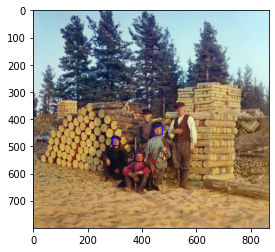

In [3]:
import cv2
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier("data/cascades/haarcascade_frontalface_default.xml")
img = cv2.imread("images/woodcutters.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.08,5)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img, (x, y),(x+w, y+h),(255,0,0), 2)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## 在视频上进行人脸检测

In [ ]:
import cv2

face_cascade = cv2.CascadeClassifier("data/cascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("data/cascades/haarcascade_eye.xml")

camera = cv2.VideoCapture(1)
while (cv2.waitKey(1) == -1):
    success, frame = camera.read()
    if success:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5, minSize=(120, 120))
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y),(x+w, y+h), (255, 0, 0), 2)
            roi_gray = gray[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray, 1.03, 5, minSize=(40,40))
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(frame, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 255, 0), 2)
        cv2.imshow("face detection", frame)

## 进行人脸识别

In [ ]:
# 生成人脸识别数据
import cv2
import os

output_folder = "data/at/wrd"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

face_cascade = cv2.CascadeClassifier("data/cascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("data/cascades/haarcascade_eye.xml")

camera = cv2.VideoCapture(1)
count = 0
while (cv2.waitKey(1) == -1):
    success, frame = camera.read()
    if success:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5, minSize=(120, 120))
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y),(x+w, y+h), (255, 0, 0), 2)
            face_img = cv2.resize(gray[y:y+h, x:x+w],(200,200))
            face_filename = f"{output_folder}/{count}.pgm"
            cv2.imwrite(face_filename, face_img)
            count += 1
        cv2.imshow("face detection", frame)

In [ ]:
# 加载人脸识别的训练数据
import os
import cv2
import numpy as np

def read_images(path, image_size):
    names = []
    training_images, training_labels = [], []
    label = 0
    for dirname, subdirnames, filenames in os.walk(path):
        for subdirname in subdirnames:
            names.append(subdirname)
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                img = cv2.imread(os.path.join(subject_path,filename), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, image_size)
                training_images.append(img)
                training_labels.append(label)
            label += 1
    training_images = np.asarray(training_images, np.uint8)
    training_labels = np.asarray(training_labels, np.int32)
    return names, training_images, training_labels
path_to_training_images = "data/at"
training_image_size = (200,200)
names, training_images, training_labels = read_images(path_to_training_images, training_image_size)

# 基于特征脸进行人脸识别

model = cv2.face.EigenFaceRecognizer_create()
model.train(training_images, training_labels)

face_cascade = cv2.CascadeClassifier("data/cascades/haarcascade_frontalface_default.xml")

camera = cv2.VideoCapture(1)
while (cv2.waitKey(1) == -1):
    success, frame = camera.read()
    if success:
        faces = face_cascade.detectMultiScale(frame, 1.3, 5)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y),(x+w, y+h), (255, 0, 0), 2)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            roi_gray = gray[x:x+w, y:y+h]
            if roi_gray.size == 0:
                continue
            roi_gray = cv2.resize(roi_gray, training_image_size)
            label, confidence = model.predict(roi_gray)
            text = f"{names[label]}, confidence={confidence:.2f}"
            cv2.putText(frame ,text, (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        cv2.imshow("face detection", frame)
cv2.destroyAllWindows()